In [20]:
import sys
import os

# Define the path to your folder
folder_path = f'..\\..\\..\\Models\\AutoDiffusion' 

sys.path.append(folder_path)

In [21]:
import math
import numpy as np
#import process_edited as pce
import process_GQ as pce
import autoencoder as ae
import diffusion as diff
import TabDDPMdiff as TabDiff
import pandas as pd
import torch
import time
import numpy as np

## Looping Through the Dataset, Everything in a single block(Still Working on it)

Recall Score for AutoDiff Autoencoder & ForestDIffusion for HTRU dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 16259, 1: 1639}
Class distribution after augmentation: {0.0: 16259, 1.0: 2458}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for HTRU dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 16259, 1: 1639}
Class distribution after augmentation: {0.0: 16259, 1.0: 3278}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for HTRU dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 16259, 1: 1639}
Class distribution after augmentation: {0.0: 16259, 1.0: 4917}


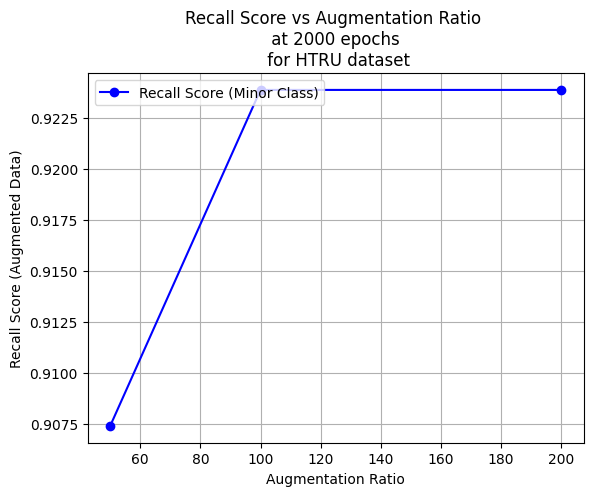

Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 284315, 1: 492}
Class distribution after augmentation: {0.0: 284315, 1.0: 738}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 284315, 1: 492}
Class distribution after augmentation: {0.0: 284315, 1.0: 984}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 284315, 1: 492}
Class distribution after augmentation: {0.0: 284315, 1.0: 1476}


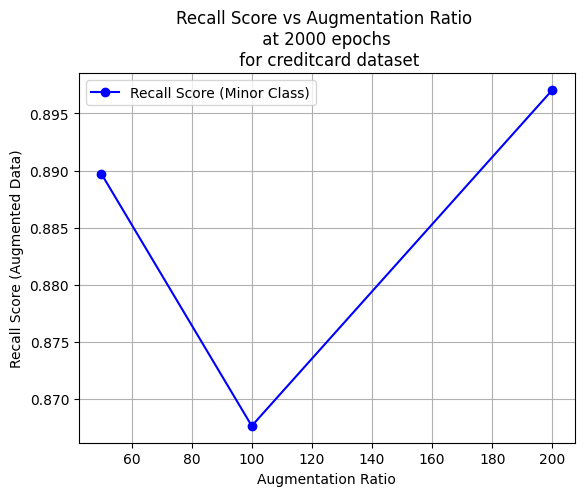

Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced_diabetes dataset


NameError: name 'minority_class' is not defined

In [ ]:
strings_set = ['diabetes','HTRU','mammography','creditcard','creditcard_sampled','spambase','reduced_diabetes','reduced_spambase']
# strings_set = {'diabetes'}
Model = 'AutoDiff'
metrics_list = []
epoch=2000
sample_size_percent_list = [50,100,200]
for dataset in strings_set:
    
    recall_list =[]
    for sample_size_percent in sample_size_percent_list:
        print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for {dataset} dataset")
        if dataset == 'creditcard':
            file_path = f'..\\..\\..\\..\\Extra_Datasets\\{dataset}.csv'
        elif dataset == 'reduced_diabetes':
            file_path = f'..\\..\\..\\Datasets\\Original Data\\diabetes.csv'
        elif dataset == 'reduced_spambase':
            file_path = f'..\\..\\..\\Datasets\\Original Data\\spambase.csv'
        else:
            file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
        # Read dataframe
        # print(file_path)
        real_df = pd.read_csv(file_path)
        #real_df = real_df.drop('url', axis=1)
        # # Step 2: Inspect the data and check for class imbalance
        # # Assuming the last column is the label, and the rest are features
        X = real_df.iloc[:, :-1].values  # Features
        y = real_df.iloc[:, -1].values  # Labels (binary classification)
        #  # Separate the minority class
        # Find the minority class
        real_minortiy = real_df[y == 1]
        if dataset == 'reduced_diabetes':
            real_minortiy = real_minortiy.sample(n=len(real_minortiy) - 68, random_state=42)
        elif dataset == 'reduced_spambase':
            real_minortiy = real_minortiy.sample(n=len(real_minortiy) - 813, random_state=42)
        threshold = 0.01 # Threshold for mixed-type variables
        parser = pce.DataFrameParser().fit(real_minortiy, threshold)
        ################################################################################################################
        # Auto-encoder hyper-parameters
        device = 'cuda' #@param {'type':'string'}
        n_epochs = epoch #@param {'type':'integer'}
        eps = 1e-5 #@param {type:"number"}
        weight_decay = 1e-6 #@param {'type':'number'}
        maximum_learning_rate = 1e-2 #@param {'type':'number'}
        lr = 2e-4 #@param {'type':'number'}
        hidden_size = 250
        num_layers = 3
        batch_size = real_minortiy.shape[0] # Full batch

        ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
        latent_features = ds[1].detach()

        from ForestDiffusion import ForestDiffusionModel


        # Convert to NumPy array
        array = latent_features.detach().cpu().numpy()
        forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
        ##### This is the improvisation to generate samples when augmentation ration is more than 100%
        div=math.ceil(sample_size_percent/100)
        gen_df = pd.DataFrame()
        for i in range (div):
            minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
            sample=torch.tensor(minority_fake, dtype=torch.float32)
            sample.shape
            gen_output = ds[0](sample, ds[2], ds[3])
            batch_df = pce.convert_to_table(real_minortiy, gen_output, threshold)
            gen_df =pd.concat([gen_df, batch_df], ignore_index=True)
            

        # output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
        # filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
        # output_file = os.path.join(output_directory, filename)
        # gen_df.to_csv(output_file, index=False) 


        # Select a random sample of the generated data
        num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
        selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
        # Syn _df will be the dataset after augmentation
        syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


        augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
        filename = f'{Model}+Forest_{dataset}_Augmented.csv'
        augmented_output_file = os.path.join(augmented_output_directory, filename)
        # syn_df.to_csv(augmented_output_file, index=False) 

        import pandas as pd
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
        import numpy as np
        import matplotlib.pyplot as plt
        from ForestDiffusion import ForestDiffusionModel
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import recall_score, f1_score

        # real_df = pd.read_csv(filename)
        # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

        # augmented_df = pd.read_csv(syn_filename)
        augmented_df=syn_df

        X = real_df.iloc[:, :-1].values  # Features
        y = real_df.iloc[:, -1].values 
        # Check and print the original class distribution
        unique, counts = np.unique(y, return_counts=True)
        class_dist_before = dict(zip(unique, counts))
        print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

        X_balanced = augmented_df.iloc[:, :-1].values  # Features
        y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

        # Check and print the Augmented class distribution
        unique, counts = np.unique(y_balanced, return_counts=True)
        class_dist_after = dict(zip(unique, counts))
        print(f"Class distribution after augmentation: {class_dist_after}")

        # Step 6: Split the dataset into training and test sets (original and balanced)
        X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

        # Step 7: Train a simple classifier on both original and generated datasets
        clf_orig = RandomForestClassifier(random_state=42)
        clf_orig.fit(X_train_orig, y_train_orig)

        clf_bal = RandomForestClassifier(random_state=42)
        clf_bal.fit(X_train_bal, y_train_bal)

        # Step 8: Predict and calculate recall and F1 scores
        y_pred_orig = clf_orig.predict(X_test_orig)
        y_pred_bal = clf_bal.predict(X_test_orig)

        prec_orig = precision_score(y_test_orig, y_pred_orig)
        prec_bal = precision_score(y_test_orig, y_pred_bal)
        
        recall_orig = recall_score(y_test_orig, y_pred_orig)
        recalls_bal = recall_score(y_test_orig, y_pred_bal)

        # f1_orig = f1_score(y_test_orig, y_pred_orig)
        # f1_bal = f1_score(y_test_orig, y_pred_bal)

        # Step 9: Print and store the performance metrics
        # Store metrics in a dictionary
        metrics = {
        "Dataset": dataset,
        "Augmentaion Ratio":f'{sample_size_percent}%',
        "Recall_Original": recall_orig,
        "Recall_Generated": recalls_bal,
        
        }

        # Append the dictionary to the list
        metrics_list.append(metrics)
        recall_list.append(recalls_bal)
        # print(f"Precision score (original data): {prec_orig:.4f}")
        # print(f"Precision score (generated data): {prec_bal:.4f}")
        # print(f"Recall score (original data): {recall_orig:.4f}")
        # print(f"Recall score (generated data): {recalls_bal:.4f}")
        # print(f"F1 score (original data): {f1_orig:.4f}")
        # print(f"F1 score (generated data): {f1_bal:.4f}")
        # print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
        # print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


        # print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")
    # Convert the list of dictionaries into a DataFrame
    import matplotlib.pyplot as plt

    # Create the plot
    plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
    # Adding title and labels
    plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
    plt.xlabel('Augmentation Ratio')
    plt.ylabel('Recall Score (Augmented Data)')
    plt.legend(loc="upper left")

    # Show the grid
    plt.grid()

    # Display the plot

    diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
    plt.savefig(diagram_name)
    plt.show()
    


## Note to self

I have till now been placing the datasets in a set accidentally and as a result iterating over the datasets is not in the order as i intented . So HTRU and creditcard dataset result has been completed. The remaining datasets will be run below

In [24]:
import pandas as pd
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame to a CSV file
metrics_df.to_csv("Auto_Diff_Forest_Different Augmentation Ratio at 2000 epochs_AIO.csv", index=False)

# Print the DataFrame
print(metrics_df)

      Dataset Augmentaion Ratio  Recall_Original  Recall_Generated
0        HTRU               50%         0.835391          0.907407
1        HTRU              100%         0.835391          0.923868
2        HTRU              200%         0.835391          0.923868
3  creditcard               50%         0.801471          0.889706
4  creditcard              100%         0.801471          0.867647
5  creditcard              200%         0.801471          0.897059


Recall Score for AutoDiff Autoencoder & ForestDIffusion for diabetes dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 402}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for diabetes dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 536}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for diabetes dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 804}


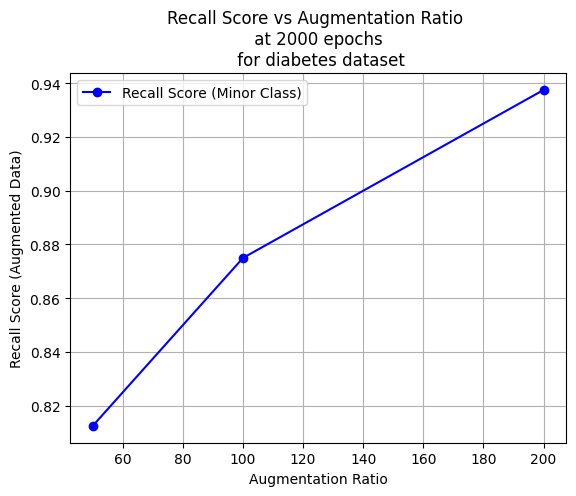

Recall Score for AutoDiff Autoencoder & ForestDIffusion for mammography dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {-1: 10923, 1: 260}
Class distribution after augmentation: {-1.0: 10923, 1.0: 390}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for mammography dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

c:\Users\Tawfique\Thesis\Llama3_8B\Llama-3.1-8B-Instruct\LlamaENVpip\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Class distribution before augmentation: {-1: 10923, 1: 260}
Class distribution after augmentation: {-1.0: 10923, 1.0: 520}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for mammography dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {-1: 10923, 1: 260}
Class distribution after augmentation: {-1.0: 10923, 1.0: 780}


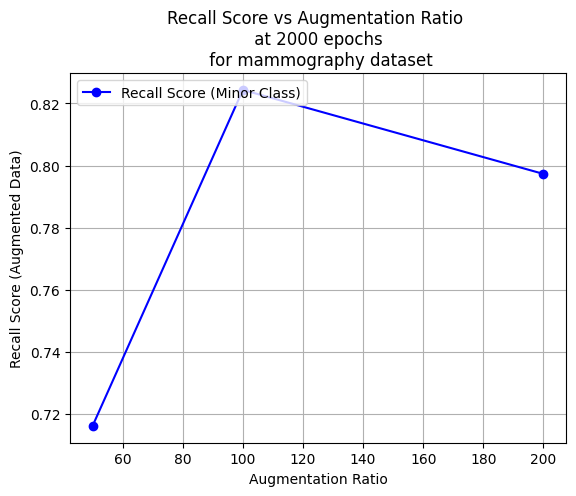

Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard_sampled dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 4000, 1: 50}
Class distribution after augmentation: {0.0: 4000, 1.0: 75}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard_sampled dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 4000, 1: 50}
Class distribution after augmentation: {0.0: 4000, 1.0: 100}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard_sampled dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 4000, 1: 50}
Class distribution after augmentation: {0.0: 4000, 1.0: 150}


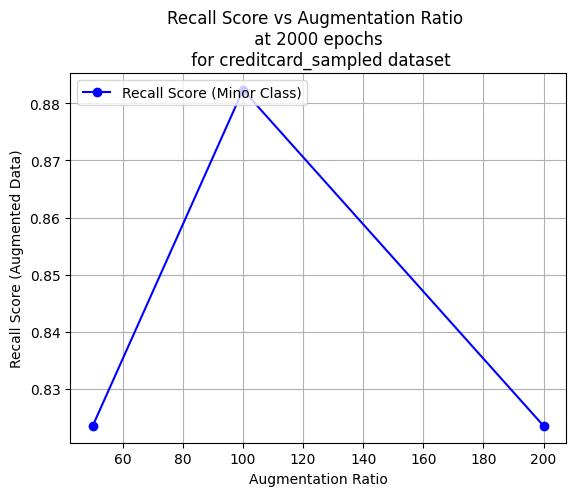

Recall Score for AutoDiff Autoencoder & ForestDIffusion for spambase dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 2788, 1: 1813}
Class distribution after augmentation: {0.0: 2788, 1.0: 2719}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for spambase dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 2788, 1: 1813}
Class distribution after augmentation: {0.0: 2788, 1.0: 3626}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for spambase dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 2788, 1: 1813}
Class distribution after augmentation: {0.0: 2788, 1.0: 5439}


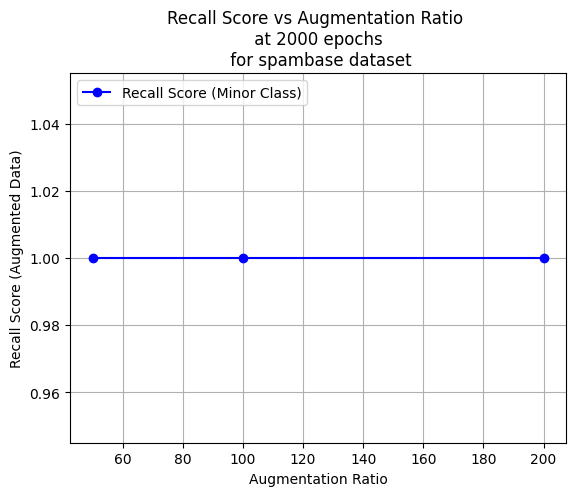

Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced_diabetes dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 368}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced_diabetes dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 468}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced_diabetes dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 668}


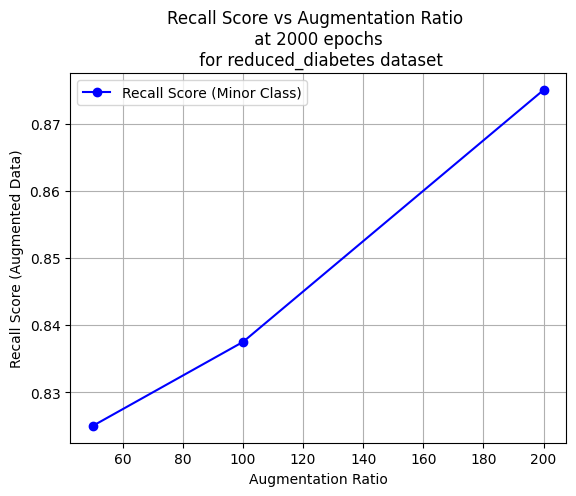

Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced_spambase dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 2788, 1: 1813}
Class distribution after augmentation: {0.0: 2788, 1.0: 2313}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced_spambase dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 2788, 1: 1813}
Class distribution after augmentation: {0.0: 2788, 1.0: 2813}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced_spambase dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 2788, 1: 1813}
Class distribution after augmentation: {0.0: 2788, 1.0: 3813}


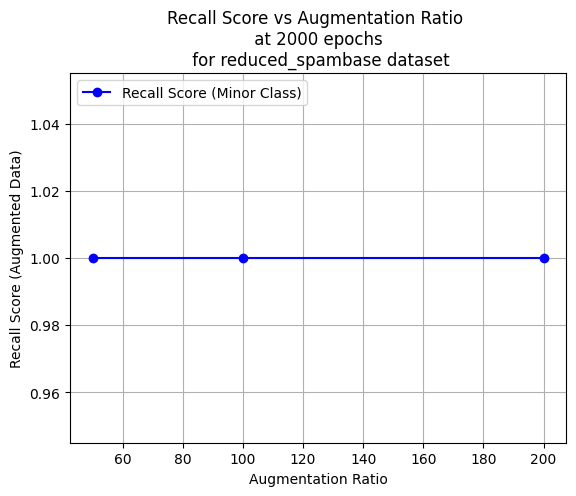

In [25]:
strings_set = ['diabetes','mammography','creditcard_sampled','spambase','reduced_diabetes','reduced_spambase']
# strings_set = {'diabetes'}
Model = 'AutoDiff'
metrics_list = []
epoch=2000
sample_size_percent_list = [50,100,200]
for dataset in strings_set:
    
    recall_list =[]
    for sample_size_percent in sample_size_percent_list:
        print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for {dataset} dataset")
        if dataset == 'creditcard':
            file_path = f'..\\..\\..\\..\\Extra_Datasets\\{dataset}.csv'
        elif dataset == 'reduced_diabetes':
            file_path = f'..\\..\\..\\Datasets\\Original Data\\diabetes.csv'
        elif dataset == 'reduced_spambase':
            file_path = f'..\\..\\..\\Datasets\\Original Data\\spambase.csv'
        else:
            file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
        # Read dataframe
        # print(file_path)
        real_df = pd.read_csv(file_path)
        #real_df = real_df.drop('url', axis=1)
        # # Step 2: Inspect the data and check for class imbalance
        # # Assuming the last column is the label, and the rest are features
        X = real_df.iloc[:, :-1].values  # Features
        y = real_df.iloc[:, -1].values  # Labels (binary classification)
        #  # Separate the minority class
        # Find the minority class
        real_minortiy = real_df[y == 1]
        if dataset == 'reduced_diabetes':
            real_minortiy = real_minortiy.sample(n=len(real_minortiy) - 68, random_state=42)
        elif dataset == 'reduced_spambase':
            real_minortiy = real_minortiy.sample(n=len(real_minortiy) - 813, random_state=42)
        threshold = 0.01 # Threshold for mixed-type variables
        parser = pce.DataFrameParser().fit(real_minortiy, threshold)
        ################################################################################################################
        # Auto-encoder hyper-parameters
        device = 'cuda' #@param {'type':'string'}
        n_epochs = epoch #@param {'type':'integer'}
        eps = 1e-5 #@param {type:"number"}
        weight_decay = 1e-6 #@param {'type':'number'}
        maximum_learning_rate = 1e-2 #@param {'type':'number'}
        lr = 2e-4 #@param {'type':'number'}
        hidden_size = 250
        num_layers = 3
        batch_size = real_minortiy.shape[0] # Full batch

        ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
        latent_features = ds[1].detach()

        from ForestDiffusion import ForestDiffusionModel


        # Convert to NumPy array
        array = latent_features.detach().cpu().numpy()
        forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
        ##### This is the improvisation to generate samples when augmentation ration is more than 100%
        div=math.ceil(sample_size_percent/100)
        gen_df = pd.DataFrame()
        for i in range (div):
            minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
            sample=torch.tensor(minority_fake, dtype=torch.float32)
            sample.shape
            gen_output = ds[0](sample, ds[2], ds[3])
            batch_df = pce.convert_to_table(real_minortiy, gen_output, threshold)
            gen_df =pd.concat([gen_df, batch_df], ignore_index=True)
            

        # output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
        # filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
        # output_file = os.path.join(output_directory, filename)
        # gen_df.to_csv(output_file, index=False) 


        # Select a random sample of the generated data
        num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
        selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
        # Syn _df will be the dataset after augmentation
        syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


        augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
        filename = f'{Model}+Forest_{dataset}_Augmented.csv'
        augmented_output_file = os.path.join(augmented_output_directory, filename)
        # syn_df.to_csv(augmented_output_file, index=False) 

        import pandas as pd
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
        import numpy as np
        import matplotlib.pyplot as plt
        from ForestDiffusion import ForestDiffusionModel
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import recall_score, f1_score

        # real_df = pd.read_csv(filename)
        # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

        # augmented_df = pd.read_csv(syn_filename)
        augmented_df=syn_df

        X = real_df.iloc[:, :-1].values  # Features
        y = real_df.iloc[:, -1].values 
        # Check and print the original class distribution
        unique, counts = np.unique(y, return_counts=True)
        class_dist_before = dict(zip(unique, counts))
        print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

        X_balanced = augmented_df.iloc[:, :-1].values  # Features
        y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

        # Check and print the Augmented class distribution
        unique, counts = np.unique(y_balanced, return_counts=True)
        class_dist_after = dict(zip(unique, counts))
        print(f"Class distribution after augmentation: {class_dist_after}")

        # Step 6: Split the dataset into training and test sets (original and balanced)
        X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
        X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

        # Step 7: Train a simple classifier on both original and generated datasets
        clf_orig = RandomForestClassifier(random_state=42)
        clf_orig.fit(X_train_orig, y_train_orig)

        clf_bal = RandomForestClassifier(random_state=42)
        clf_bal.fit(X_train_bal, y_train_bal)

        # Step 8: Predict and calculate recall and F1 scores
        y_pred_orig = clf_orig.predict(X_test_orig)
        y_pred_bal = clf_bal.predict(X_test_orig)

        prec_orig = precision_score(y_test_orig, y_pred_orig)
        prec_bal = precision_score(y_test_orig, y_pred_bal)
        
        recall_orig = recall_score(y_test_orig, y_pred_orig)
        recalls_bal = recall_score(y_test_orig, y_pred_bal)

        # f1_orig = f1_score(y_test_orig, y_pred_orig)
        # f1_bal = f1_score(y_test_orig, y_pred_bal)

        # Step 9: Print and store the performance metrics
        # Store metrics in a dictionary
        metrics = {
        "Dataset": dataset,
        "Augmentaion Ratio":f'{sample_size_percent}%',
        "Recall_Original": recall_orig,
        "Recall_Generated": recalls_bal,
        
        }

        # Append the dictionary to the list
        metrics_list.append(metrics)
        recall_list.append(recalls_bal)
        # print(f"Precision score (original data): {prec_orig:.4f}")
        # print(f"Precision score (generated data): {prec_bal:.4f}")
        # print(f"Recall score (original data): {recall_orig:.4f}")
        # print(f"Recall score (generated data): {recalls_bal:.4f}")
        # print(f"F1 score (original data): {f1_orig:.4f}")
        # print(f"F1 score (generated data): {f1_bal:.4f}")
        # print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
        # print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


        # print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")
    # Convert the list of dictionaries into a DataFrame
    import matplotlib.pyplot as plt

    # Create the plot
    plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
    # Adding title and labels
    plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
    plt.xlabel('Augmentation Ratio')
    plt.ylabel('Recall Score (Augmented Data)')
    plt.legend(loc="upper left")

    # Show the grid
    plt.grid()

    # Display the plot

    diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
    plt.savefig(diagram_name)
    plt.show()

In [26]:
import pandas as pd
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame to a CSV file
metrics_df.to_csv("Auto_Diff_Forest_Different No. of Epochs at 100 percent augmentaion ratio.csv", index=False)

# Print the DataFrame
print(metrics_df)

               Dataset Augmentaion Ratio  Recall_Original  Recall_Generated
0             diabetes               50%         0.662500          0.812500
1             diabetes              100%         0.662500          0.875000
2             diabetes              200%         0.662500          0.937500
3          mammography               50%         0.594595          0.716216
4          mammography              100%         0.594595          0.824324
5          mammography              200%         0.594595          0.797297
6   creditcard_sampled               50%         0.764706          0.823529
7   creditcard_sampled              100%         0.764706          0.882353
8   creditcard_sampled              200%         0.764706          0.823529
9             spambase               50%         1.000000          1.000000
10            spambase              100%         1.000000          1.000000
11            spambase              200%         1.000000          1.000000
12    reduce

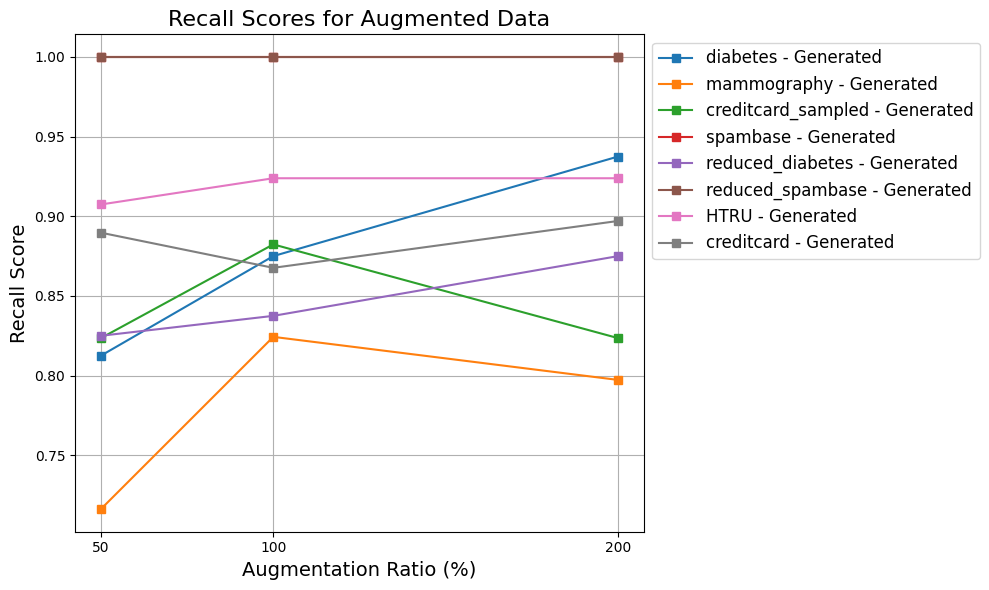

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'Auto_Diff_Forest_Different Augmentation Ratio(50,100,200) at 2000 epochs.csv'
data = pd.read_csv(file_path)

# Preprocess the data: Convert 'Augmentaion Ratio' to numeric for sorting
data['Augmentaion Ratio'] = data['Augmentaion Ratio'].str.rstrip('%').astype(float)

# Group data by dataset for plotting
datasets = data['Dataset'].unique()

# Plot recall scores for generated data only
plt.figure(figsize=(10, 6))

for dataset in datasets:
    subset = data[data['Dataset'] == dataset]
    plt.plot(
        subset['Augmentaion Ratio'], subset['Recall_Generated'], 
        marker='s', label=f'{dataset} - Generated'
    )

# Add labels, title, and legend
plt.title('Recall Scores for Augmented Data', fontsize=16)
plt.xlabel('Augmentation Ratio (%)', fontsize=14)
plt.ylabel('Recall Score', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(data['Augmentaion Ratio'].unique())
plt.tight_layout()

# Position the legend outside the plot
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Save the plot in high resolution
output_path = 'Recall Score vs Augmentation Ratio(50,100,200)_(AutoDiffandForest)_2.png'
plt.savefig(output_path, dpi=300)
plt.show()
